In [1]:
import pathlib
import json

# data
import xarray
import numpy as np
import pandas as pd

# plotting
import cmocean.cm
import matplotlib
import matplotlib.pyplot as plt
import osgeo.osr

# 3d
from tvtk.api  import tvtk
from mayavi import mlab


In [10]:
ds_path = pathlib.Path('~/data/odv/climatology/Water_body_Salinity_NorthSea.4Danl_monthly.nc').expanduser()
ds_path = pathlib.Path('/Users/baart_f/data/odv/climatology/SDN_NorthAtlanticOcean_Clim.nc').expanduser()

wgs84 = osgeo.osr.SpatialReference()
webmercator = osgeo.osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
webmercator.ImportFromEPSG(3857)
wgs2wm =  osgeo.osr.CoordinateTransformation(wgs84, webmercator)

In [11]:
def attribute_names(ds, attribute='standard_name'):
    attr_by_var = {}
    for var in ds.variables:
        attrs = getattr(ds, var).attrs    
        try:
            attr_by_var[attrs[attribute]] = var
        except KeyError:
            pass
    return attr_by_var

        

    

In [12]:
ds = xarray.open_dataset(ds_path)

attribute_names(ds, 'long_name')


{'Time': 'time',
 'Altitude': 'altitude',
 'Latitude': 'latitude',
 'Longitude': 'longitude',
 'Salinity': 'Salinity',
 'Error standard deviation of Salinity': 'Salinity_err',
 'Salinity masked using relative error threshold 0.3': 'Salinity_L1',
 'Salinity masked using relative error threshold 0.5': 'Salinity_L2',
 'Relative error of Salinity': 'Salinity_relerr',
 'Logarithm10 of number of data in bins': 'Temperature_databins',
 'Logarithm10 of number of outliers data in bins': 'Temperature_outlbins',
 'Correlation length field': 'Temperature_CLfield',
 'Temperature': 'Temperature',
 'Error standard deviation of Temperature': 'Temperature_err',
 'Temperature masked using relative error threshold 0.3': 'Temperature_L1',
 'Temperature masked using relative error threshold 0.5': 'Temperature_L2',
 'Relative error of Temperature': 'Temperature_relerr'}

In [13]:
def compute_contours(ds_path, variable='Temperature', percentiles=None):
    """compute a set  of contours for a dataset"""
    ds = xarray.open_dataset(ds_path)
    ds = ds.isel(time=1)
    
    
    # guess the names 
    # not generic, but input data is not well defined
    # multiple lat/lon in one file
    # standard names not always filled in
    names = list(ds.variables)
    if 'lat' in names:
        lat_name = 'lat'
    elif 'latitude' in names:
        lat_name = 'latitude'
    if 'lon' in names:
        lon_name = 'lon'
    elif 'longitude' in names:
        lon_name = 'longitude'
    
    lat = getattr(ds, lat_name)
    lon = getattr(ds, lon_name)
    
    if 'depth' in names:
        height = -ds.depth.values
    elif 'altitude' in names:
        height = ds.altitude.values
    
    meta = {}

    arr = np.squeeze(getattr(ds, variable).values)

    var_min = np.nanmin(arr)
    var_max = np.nanmax(arr)

    q = [0.01, 0.05, 0.1, 0.25,  0.5,  0.75, 0.9, 0.95,  0.99]
    if percentiles  is None:
        percentiles = np.nanpercentile(arr, q)
    
    

    meta['variable'] = variable
    meta['var_min'] = var_min
    meta['var_max'] = var_max
    meta['percentiles'] = percentiles.tolist()

    # change dimenions  to x,y,z
    arr = np.moveaxis(arr, [0, 1, 2], [2, 1, 0])

    arr_masked = np.ma.masked_invalid(arr)
    arr_filled = arr_masked.filled(0).copy()

    Lat, Lon, Z = np.meshgrid(lat.values, lon.values, height)
    xyz = np.array(wgs2wm.TransformPoints(np.c_[Lat.ravel(), Lon.ravel()]))
    X =  xyz[:, 0].reshape(Lon.shape)
    Y =  xyz[:, 1].reshape(Lat.shape)
    
    x_min, x_max = X.min(), X.max()
    y_min, y_max = Y.min(), Y.max()
    z_min, z_max = Z.min(), Z.max()
    
    lat_min, lat_max = Lat.min(), Lat.max()
    lon_min, lon_max = Lon.min(), Lon.max()
    
    meta['x_min'] = x_min
    meta['x_max'] = x_max
    meta['y_min'] = y_min
    meta['y_max'] = y_max
    meta['z_min'] = z_min
    meta['z_max'] = z_max
    meta['lat_min'] = lat_min
    meta['lat_max'] = lat_max
    meta['lon_min'] = lon_min
    meta['lon_max'] = lon_max
    
    isos = [
        # swap Z and Y for 3d 
        mlab.contour3d(X, Y, Z, arr_filled,  contours=[percentile])
        for percentile
        in percentiles
    ]

    contours = []
    for iso in isos:
        contour = iso.contour
        contour.minimum_contour = var_min
        contour.filled_contours = False
        contour.outputs[0].update()
        contours.append(contour.outputs[0].output)
    return meta, contours

In [14]:
meta, contours =  compute_contours(ds_path, variable='Temperature', percentiles = np.array([6, 8,  10, 12, 14, 16.0]))



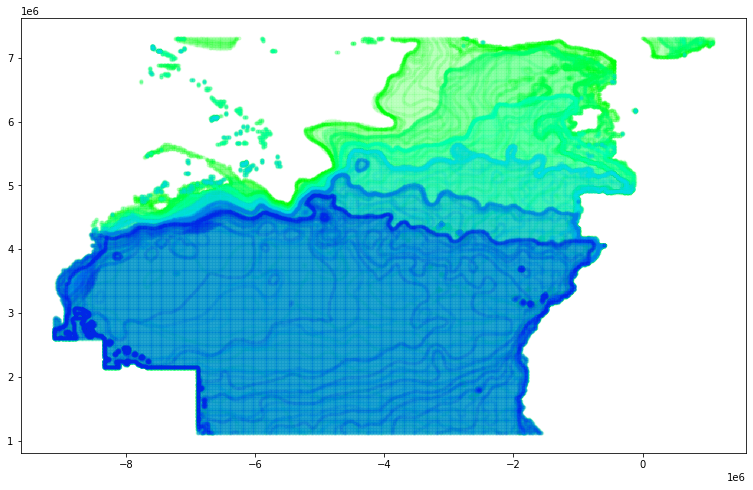

In [15]:
N = matplotlib.colors.Normalize(meta['var_min'], meta['var_max'])
colors = matplotlib.cm.hsv(N(meta['percentiles']))

fig, ax = plt.subplots(figsize=(13, 8))
for color, contour, percentile in list(zip(colors, contours, meta['percentiles'])):
    df =  pd.DataFrame(contour.points, columns=['x', 'y', 'z'])
    ax.plot(df.x, df.y, '.', alpha=0.04, color=color)

In [16]:
base_dir = ds_path.with_suffix('') 
base_dir.mkdir(exist_ok=True)

paths = []


for i, (color, contour, percentile) in enumerate(zip(colors, contours, meta['percentiles'])):
    
    smooth = tvtk.SmoothPolyDataFilter()
    smooth.relaxation_factor  = 0.01
    smooth.add_input_data_object(contour)
    smooth.update()
    
    transform_filter = tvtk.TransformFilter()
    transform = tvtk.Transform()
    x_min = meta['x_min']
    x_max = meta['x_max']
    y_min = meta['y_min']
    y_max = meta['y_max']
    z_min = meta['z_min']
    z_max = meta['z_max']
    lat_min = meta['lat_min'] 
    lat_max = meta['lat_max'] 
    lon_min = meta['lon_min'] 
    lon_max = meta['lon_max'] 

    transform.translate(-x_min, -y_min, -z_min)
    # transform.scale(1/(x_max - x_min), 1/(y_max - y_min), 1/(z_max - z_min))
    transform_filter.transform = transform
    transform_filter.add_input_data_object(smooth.output)
    transform_filter.update()
    base_path = base_dir / "polydata-{}-{:04d}".format(meta['variable'], i)
    
    ply_path = base_path.with_suffix('.ply')
    vtk_path = base_path.with_suffix('.vtk')
    paths.append(str(ply_path.relative_to(base_dir)))
    
    writer = tvtk.DataSetWriter(file_name=str(vtk_path))
    # writer = tvtk.PLYWriter(file_name=str(ply_path))
    writer.add_input_data_object(smooth.output)
    writer.update()
    print('min', np.array(writer.input.points).min(axis=0))
    print('max', np.array(writer.input.points).max(axis=0))
    writer.write()
    
meta['paths'] = paths
    
with base_path.with_suffix('.json').open('w') as f:
    pd.Series(meta).to_json(f)
    
    


min [-9.12297600e+06  1.11889000e+06 -1.65077209e+03]
max [1090775.125 7315219.      10500.   ]
min [-9.12123500e+06  1.11889000e+06 -1.24201196e+03]
max [1090775.125 7315219.      10500.   ]
min [-9.11949400e+06  1.11889000e+06 -1.02982764e+03]
max [1070784.625 7315219.      10500.   ]
min [-9.11775300e+06  1.11889000e+06 -5.26305542e+02]
max [ 646131.5625 7249214.       10500.    ]
min [-9.11601400e+06  1.11889000e+06  2.91088843e+03]
max [-598446.125 5414628.      10500.   ]
min [-9.11427800e+06  1.11889000e+06  3.37297021e+03]
max [-601225.375 4858223.      10500.   ]


In [17]:
!open  $base_dir

In [18]:
writer.input.print_traits()

_in_set:                   0
_vtk_obj:                  (vtkCommonDataModelPython.vtkPolyData)0x148942c20
actual_memory_size:        5488
bounds:                    (-9114278.0, -601225.375,...72.97021484375, 10500.0)
cell_data:                 <tvtk.tvtk_classes.cell_d...a object at 0x12b18e650>
cell_ghost_array:          None
center:                    (-4857751.6875, 2988556.5, 6936.485107421875)
class_name:                'vtkPolyData'
data_object_type:          0
data_released:             0
debug:                     False
debug_:                    0
extent_type:               0
field_data:                <tvtk.tvtk_classes.field_...a object at 0x12affd170>
ghost_level:               0
global_release_data_flag:  0
global_release_data_flag_: 0
global_warning_display:    1
global_warning_display_:   1
information:               <tvtk.tvtk_classes.inform...n object at 0x12affd170>
length:                    9298103.412818227
lines:                     <tvtk.tvtk_classes.cell_a...y 

In [77]:
np.array(smooth.output.points).min(axis=0)

array([-1029705.3125    ,  3550738.25      ,     4953.45214844])

In [76]:
np.array(smooth.output.points).max(axis=0)


array([4022811.25, 4532542.  ,   10500.  ])

In [104]:
[x for x in dir(tvtk) if 'writer' in x.lower()]

['AbstractParticleWriter',
 'ArrayDataWriter',
 'ArrayWriter',
 'BMPWriter',
 'BYUWriter',
 'CompositeDataWriter',
 'DIMACSGraphWriter',
 'DataObjectWriter',
 'DataSetWriter',
 'DataWriter',
 'DelimitedTextWriter',
 'EnSightWriter',
 'ExodusIIWriter',
 'FacetWriter',
 'GenericDataObjectWriter',
 'GenericMovieWriter',
 'GraphWriter',
 'HoudiniPolyDataWriter',
 'IVWriter',
 'ImageWriter',
 'JPEGWriter',
 'JSONImageWriter',
 'JavaScriptDataWriter',
 'MCubesWriter',
 'MINCImageWriter',
 'MNIObjectWriter',
 'MNITagPointWriter',
 'MNITransformWriter',
 'MetaImageWriter',
 'NIFTIImageWriter',
 'NewickTreeWriter',
 'OggTheoraWriter',
 'PDataSetWriter',
 'PImageWriter',
 'PLYWriter',
 'PNGWriter',
 'PNMWriter',
 'PhyloXMLTreeWriter',
 'PolyDataWriter',
 'PostScriptWriter',
 'RectilinearGridWriter',
 'STLWriter',
 'SimplePointsWriter',
 'StructuredGridWriter',
 'StructuredPointsWriter',
 'TIFFWriter',
 'TableToDatabaseWriter',
 'TableToSQLiteWriter',
 'TableWriter',
 'TreeWriter',
 'Unstructured

In [107]:
tvtk.PolyDataWriter?